In [1]:
"""
Similar to the user transfer matrix, this notebook plots the number of overlapping actions between train-users in a heatmap.

Before running this experiment, make sure you have run the Stream meta-data collector (src/continual_ego4d/processing/run_summarize_user_streams.py) and set the resulting paths in this notebook.
"""
import datetime
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [2]:
"""
CONFIG: Add your config params here
"""

########### PLOT CONFIG ###############
TRAIN_USERS_MODE = True

if TRAIN_USERS_MODE:  # Path obtained by Stream meta-data collector (src/continual_ego4d/processing/run_summarize_user_streams.py)
    FILE_TO_ANALYZE = "/your/path/to/logs/2022-10-07_04-49-02_UIDa5c4c52b-a8d8-4155-b1f4-bed9cd82374e/dataset_entries_train_ego4d_LTA_train_usersplit_10users.ckpt"

else:  # Path obtained by Stream meta-data collector (src/continual_ego4d/processing/run_summarize_user_streams.py)
    FILE_TO_ANALYZE = "/your/path/to/logs/2022-10-07_04-33-34_UIDd679068a-dc6e-40ff-b146-70ffe0671a97/dataset_entries_test_ego4d_LTA_test_usersplit_40users.ckpt"

# Output configs
title = "transfer_eval_label_IOU"
main_outdir = "../imgs/transfer_eval_label_overlap"

{'104':      clip_start_sec  clip_end_sec  noun_label  \
 0         15.087695     17.221029          97   
 1         17.221029     19.354362          97   
 2         19.354362     21.487695          97   
 3         23.087695     25.221029          97   
 4         26.254362     28.387695          97   
 ..              ...           ...         ...   
 522      272.377695    274.511029         120   
 523      274.511029    276.644362         120   
 524      289.377695    291.511029         158   
 525      291.511029    293.644362         158   
 526      293.644362    295.777695         158   
 
                                            noun  verb_label  \
 0    cloth_(cloth,_fabric,_garment,_kanga,_rag)          99   
 1    cloth_(cloth,_fabric,_garment,_kanga,_rag)          99   
 2    cloth_(cloth,_fabric,_garment,_kanga,_rag)          99   
 3    cloth_(cloth,_fabric,_garment,_kanga,_rag)          65   
 4    cloth_(cloth,_fabric,_garment,_kanga,_rag)          35   
 ..    

In [ ]:
"""Get dictionary with dataframe per user stream (includes all labels and other meta data)."""

with open(FILE_TO_ANALYZE, 'rb') as f:
    ds = pickle.load(f)

""" Create DF """


def ds_to_user_dfs(ds):
    ret = {}
    for user, user_entries in ds.items():
        # Do all for actions/verbs/nouns
        user_df = pd.json_normalize(user_entries)  # Convert to DF

        # Create action column
        def label_fn(x):
            assert len(x) == 2, "Need two columns to merge"
            if not isinstance(x[0], list):
                assert not isinstance(x[1], list)
                return f"{x[0]}-{x[1]}"

            return [f"{l}-{r}" for l, r in zip(x[0], x[1])]

        user_df['action_label'] = user_df.loc[:, ('verb_label', 'noun_label')].apply(label_fn, axis=1)
        ret[user] = user_df
    return ret


# MAIN SCRIPT
user_dfs = ds_to_user_dfs(ds)  # Preprocess dataframes

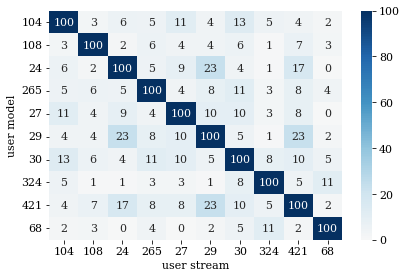

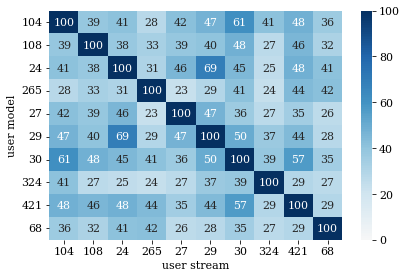

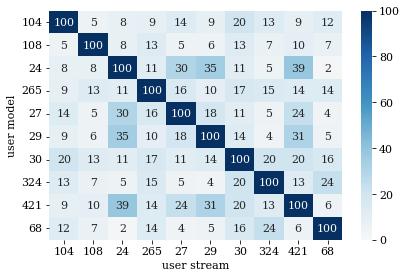

In [5]:
cmap = sns.color_palette('RdBu', as_cmap=True)  # "gist_heat"
modes = ['action', 'verb', 'noun']

# Paths
parent_dirname = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + title
parent_dirpath = os.path.join(main_outdir, parent_dirname)
filename = f"{{}}_{title}.pdf"

os.makedirs(parent_dirpath, exist_ok=True)

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 11

vmaxes = [100] * 3  # All same scale
vmins = [0] * 3


def get_overlap_matrix(user_dfs, action_mode, users: list[str]):
    #     matrix_idx_to_trainuser = ["104", "108", "24", "265", "27", "29", "30", "324", "421", "68"]
    matrix_idx_to_trainuser = users
    trainuser_to_matrix_idx = {matrix_idx: trainuser for matrix_idx, trainuser in enumerate(matrix_idx_to_trainuser)}

    if mode == "action":
        label_col_name = 'action_label'

    elif mode == "verb":
        label_col_name = 'verb_label'

    elif mode == "noun":
        label_col_name = 'noun_label'

    else:
        raise ValueError()

    # Get per user set of unique labels
    user_to_labelset = {}
    for user in matrix_idx_to_trainuser:
        user_labelset = set(user_dfs[user][label_col_name].tolist())
        user_to_labelset[user] = user_labelset

    # Get matrix 
    matrix = [[-1 for _ in range(len(matrix_idx_to_trainuser))] for _ in range(len(matrix_idx_to_trainuser))]
    for row_idx, row_user in enumerate(matrix_idx_to_trainuser):
        row_user_labelset = user_to_labelset[row_user]
        for col_idx, col_user in enumerate(matrix_idx_to_trainuser):
            col_user_labelset = user_to_labelset[col_user]

            # Intersection vs total percentage: IOU
            intersect = row_user_labelset.intersection(col_user_labelset)
            union = row_user_labelset.union(col_user_labelset)
            iou = round(len(intersect) / len(union) * 100)

            matrix[row_idx][col_idx] = iou

    return matrix


for mode_idx, mode in enumerate(modes):
    train_users = ["104", "108", "24", "265", "27", "29", "30", "324", "421", "68"]
    matrix = get_overlap_matrix(user_dfs, mode, train_users)

    input_matrix = np.array(matrix, dtype=float)  # Square matrix
    assert len(input_matrix) == len(input_matrix[0]), "Must be square"

    # Round
    input_matrix = input_matrix.round(decimals=2)

    # Heatmap
    vmax = vmaxes[mode_idx]
    vmin = vmins[mode_idx]
    x_labels = y_labels = train_users
    ax = sns.heatmap(input_matrix, center=0, cmap='RdBu', annot=True, fmt='.0f', vmin=vmin, vmax=vmax,
                     xticklabels=x_labels, yticklabels=y_labels)
    plt.yticks(rotation=0)
    plt.xlabel("user stream")
    plt.ylabel("user model")

    fig = ax.get_figure()

    fig.tight_layout()
    path = os.path.join(parent_dirpath, filename.format(mode))
    fig.savefig(path, )
    plt.show()